# Explora a base de Rotas Potenciais da plataforma Horus
1. Identifica relação de demanda com indicadores socioeconômicos
2. Identifica relação distância e tarifa

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# Utilizando o engine 'openpyxl' para ler o arquivo Excel
rotas_potenciais = pd.read_excel(
    'data/excel/xlsx/Estudo Rotas Potenciais.xlsx', 
    engine='openpyxl'  # Usar o openpyxl para leitura
)

In [4]:
# Utilizando o engine 'openpyxl' para ler o arquivo Excel
base_municipios = pd.read_excel(
    'data/excel/xlsx/Lista de municipios e UTPs.xlsx', 
    engine='openpyxl'  # Usar o openpyxl para leitura
)

In [5]:
base_municipios.columns

Index(['idMunicipio', 'codigo', 'nome', 'uf', 'idUtp', 'utp'], dtype='object')

In [6]:
matriz_od= pd.read_csv('data/csv/matriz_od_turismo.csv', delimiter = ',')

In [7]:
list(rotas_potenciais.columns)

['O',
 'D',
 'Soma de Aéreo',
 'Soma de Não aéreo',
 'Soma de Dúvida',
 'Total',
 'Origem',
 'Destino',
 'Share Aéreo %',
 'Lat O',
 'Long O',
 'Lat D',
 'Long D',
 'Distância aérea',
 'Classe de distância (até)',
 'Estranho',
 '% Pop O acima de 2 SM',
 '% Pop D acima de 2 SM',
 'Demanda potencial (novas ligações)',
 'Demanda potencial (adicional)',
 'Demanda potencial considerada atualizada 2019',
 'Filtro rotas potenciais',
 'Voos comerciais 2019',
 'Chave',
 'demanda anualizada anac (2019)',
 'UTP com aeroportos previstos no PAN O',
 'UTP com aeroportos previstos no PAN D',
 'Cenário PAN 2018-2038 + operantes 2019',
 'IBGE sede da UTP O',
 'IBGE sede da UTP D',
 'Aeroporto mais próximo da ponta sem atendimento',
 'Chave.1',
 'Tempo até o aero mais próximo (Min)',
 'Fator custo',
 'Demanda migrada para o aeroporto mais próximo (grav)',
 'UTP do aeroporto alimentado',
 'Rota alimentada',
 'Demanda acrescida de UTPs próximas',
 'Coordenadas',
 'X A',
 'Y A',
 'X B',
 'Y B',
 'Geom|Chav

In [8]:
distancia_classes_unicas = sorted(rotas_potenciais['Classe de distância (até)'].unique())
distancia_classes_unicas

[60.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 5000.0, nan]

In [9]:
def filtrar_e_renomear_rotas_potenciais(df, base_municipios):
    # Dicionário de renomeação
    renomeacao = {
        'Origem': 'origem',
        'UF O': 'uf_origem',
        'Destino': 'destino',
        'UF D': 'uf_destino',
        'Soma de Aéreo': 'demanda_aero',
        'Soma de Não aéreo': 'demanda_rodo',
        'Soma de Dúvida': 'demanda_reprimida',
        'Total': 'demanda_total',
        'Share Aéreo %': 'share_aero',
        'Demanda potencial (novas ligações)': 'potencial_nova_lig',
        'Demanda potencial (adicional)': 'potencial_adicional',
        'Distância aérea': 'distancia',
        'Tarifa média': 'tarifa',
        '% Pop O acima de 2 SM': 'pop_acima_2sm_origem',
        '% Pop D acima de 2 SM': 'pop_acima_2sm_destino'
    }
    
    # Renomear colunas de acordo com o dicionário
    df.rename(columns=renomeacao, inplace=True)

    # Remover linhas onde 'origem' ou 'destino' são NaN
    df = df.dropna(subset=['origem', 'destino'])

    # Corrigir o nome "São João Del Rei" para "São João del Rei" em base_municipios
    base_municipios['nome'] = base_municipios['nome'].replace("São João Del Rei", "São João del Rei")

    # Criar uma coluna de chave de correspondência em base_municipios
    base_municipios['chave'] = base_municipios['nome'] + ' - ' + base_municipios['uf']

    # Adicionar 'cod_mun_origem' com base na correspondência entre 'origem' e 'chave'
    df = df.merge(base_municipios[['chave', 'codigo']], left_on='origem', right_on='chave', how='left').rename(
        columns={'codigo': 'cod_mun_origem'}).drop(columns=['chave'])

    # Adicionar 'cod_mun_destino' com base na correspondência entre 'destino' e 'chave'
    df = df.merge(base_municipios[['chave', 'codigo']], left_on='destino', right_on='chave', how='left').rename(
        columns={'codigo': 'cod_mun_destino'}).drop(columns=['chave'])

    # Colunas desejadas no DataFrame final
    colunas_desejadas = [
        'origem', 'cod_mun_origem', 'uf_origem',
        'cod_mun_destino', 'destino', 'uf_destino',
        'demanda_aero', 'demanda_rodo', 'demanda_reprimida',
        'demanda_total', 'share_aero', 'potencial_nova_lig',
        'potencial_adicional', 'distancia', 'tarifa',
        'pop_acima_2sm_origem', 'pop_acima_2sm_destino'
    ]
    
    # Filtrar o DataFrame para conter apenas as colunas desejadas
    colunas_presentes = [col for col in colunas_desejadas if col in df.columns]
    
    # Reorganizar e filtrar o DataFrame final
    df_filtrado = df[colunas_presentes].copy()

    return df_filtrado

In [10]:
rotas_potenciais_filtrado = filtrar_e_renomear_rotas_potenciais(rotas_potenciais, base_municipios)

In [11]:
rotas_potenciais_filtrado.columns

Index(['origem', 'cod_mun_origem', 'uf_origem', 'cod_mun_destino', 'destino',
       'uf_destino', 'demanda_aero', 'demanda_rodo', 'demanda_reprimida',
       'demanda_total', 'share_aero', 'potencial_nova_lig',
       'potencial_adicional', 'distancia', 'tarifa', 'pop_acima_2sm_origem',
       'pop_acima_2sm_destino'],
      dtype='object')

In [12]:
matriz_od.columns

Index(['mun_origem', 'mun_destino', 'distancia', 'pib_origem', 'pib_destino',
       'pop_origem', 'pop_destino', 'turismo_origem', 'turismo_destino'],
      dtype='object')

In [13]:
def calcular_pib_per_capita(matriz_od):
    matriz_od['pib_per_capita_origem'] = matriz_od['pib_origem'] / matriz_od['pop_origem']
    matriz_od['pib_per_capita_destino'] = matriz_od['pib_destino'] / matriz_od['pop_destino']
    return matriz_od

matriz_od = calcular_pib_per_capita(matriz_od)

In [14]:
def remover_infinitos_e_nulos(matriz_od):
    matriz_od.replace([np.inf, -np.inf], pd.NA, inplace=True)
    matriz_od.dropna(subset=['pib_per_capita_origem', 'pib_per_capita_destino'], inplace=True)
    return matriz_od

matriz_od = remover_infinitos_e_nulos(matriz_od)

In [15]:
def definir_classes_distancia_otimizada(matriz_od, distancia_classes_unicas):
    # Remover NaN e ordenar a lista de classes de distância
    distancia_classes_unicas = sorted([x for x in distancia_classes_unicas if pd.notna(x)])
    
    # Definir limites e rótulos com base na lista fornecida
    limites = [-float('inf')] + distancia_classes_unicas + [float('inf')]
    rotulos = [f"até {limites[1]}"] + \
              [f"entre {limites[i]} e {limites[i + 1]}" for i in range(1, len(limites) - 2)] + \
              [f"acima de {limites[-2]}"]

    # Adicionar a coluna classe_distancia diretamente no DataFrame sem cópia
    matriz_od['classe_distancia'] = pd.cut(matriz_od['distancia'], bins=limites, labels=rotulos, right=True)

    return matriz_od

matriz_od = definir_classes_distancia_otimizada(matriz_od, distancia_classes_unicas)

In [16]:
def criar_variaveis_dummy_classe_distancia(matriz_od):
    dummies_classe_distancia = pd.get_dummies(matriz_od['classe_distancia'], prefix='classe_distancia', drop_first=True)
    matriz_od = pd.concat([matriz_od, dummies_classe_distancia], axis=1)
    return matriz_od

matriz_od = criar_variaveis_dummy_classe_distancia(matriz_od)

In [17]:
# Lista de classes populacionais atualizadas
pop_classes_unicas = [10000, 25000, 50000, 100000, 250000, 500000, 1000000, 3000000]

In [18]:
def definir_classes_populacao(matriz_od, pop_classes_unicas):
    # Ordenar e definir limites e rótulos com base nas classes fornecidas
    pop_classes_unicas = sorted([x for x in pop_classes_unicas if pd.notna(x)])
    limites = [-float('inf')] + pop_classes_unicas + [float('inf')]
    rotulos = [f"até {limites[1]}"] + \
              [f"entre {limites[i]} e {limites[i + 1]}" for i in range(1, len(limites) - 2)] + \
              [f"acima de {limites[-2]}"]

    # Adicionar colunas de classe para pop_origem e pop_destino
    matriz_od['classe_pop_origem'] = pd.cut(matriz_od['pop_origem'], bins=limites, labels=rotulos, right=True)
    matriz_od['classe_pop_destino'] = pd.cut(matriz_od['pop_destino'], bins=limites, labels=rotulos, right=True)

    return matriz_od

matriz_od = definir_classes_populacao(matriz_od, pop_classes_unicas)

In [19]:
def criar_variaveis_dummy_classe_populacao(matriz_od):
    # Criar variáveis dummy para classe_pop_origem e classe_pop_destino
    dummies_origem = pd.get_dummies(matriz_od['classe_pop_origem'], prefix='classe_pop_origem', drop_first=True)
    dummies_destino = pd.get_dummies(matriz_od['classe_pop_destino'], prefix='classe_pop_destino', drop_first=True)

    # Concatenar as dummies com o DataFrame original
    matriz_od = pd.concat([matriz_od, dummies_origem, dummies_destino], axis=1)
    
    return matriz_od

matriz_od = criar_variaveis_dummy_classe_populacao(matriz_od)

In [20]:
def adicionar_demandas_matriz_od(matriz_od, rotas_potenciais_filtrado):
    # Selecionar as colunas relevantes de rotas_potenciais_filtrado
    colunas_selecionadas = [
        'cod_mun_origem', 'cod_mun_destino', 'demanda_aero', 'demanda_rodo', 
        'demanda_reprimida', 'demanda_total', 'share_aero', 'tarifa', 
        'pop_acima_2sm_origem', 'pop_acima_2sm_destino'
    ]
    rotas_selecionadas = rotas_potenciais_filtrado[colunas_selecionadas]
    
    # Realizar o merge utilizando as correspondências e preservando apenas as linhas com correspondência
    matriz_od_avaliacao = matriz_od.merge(
        rotas_selecionadas,
        left_on=['mun_origem', 'mun_destino'],
        right_on=['cod_mun_origem', 'cod_mun_destino'],
        how='inner'  # Apenas linhas com correspondência serão mantidas
    )
    
    # Remover as colunas de chave extras (cod_mun_origem e cod_mun_destino) após o merge
    matriz_od_avaliacao = matriz_od_avaliacao.drop(columns=['cod_mun_origem', 'cod_mun_destino'])
        
    return matriz_od_avaliacao

matriz_od_avaliacao = adicionar_demandas_matriz_od(matriz_od, rotas_potenciais_filtrado)

In [21]:
matriz_od_avaliacao.columns

Index(['mun_origem', 'mun_destino', 'distancia', 'pib_origem', 'pib_destino',
       'pop_origem', 'pop_destino', 'turismo_origem', 'turismo_destino',
       'pib_per_capita_origem', 'pib_per_capita_destino', 'classe_distancia',
       'classe_distancia_entre 60.0 e 100.0',
       'classe_distancia_entre 100.0 e 250.0',
       'classe_distancia_entre 250.0 e 500.0',
       'classe_distancia_entre 500.0 e 750.0',
       'classe_distancia_entre 750.0 e 1000.0',
       'classe_distancia_entre 1000.0 e 5000.0',
       'classe_distancia_acima de 5000.0', 'classe_pop_origem',
       'classe_pop_destino', 'classe_pop_origem_entre 10000 e 25000',
       'classe_pop_origem_entre 25000 e 50000',
       'classe_pop_origem_entre 50000 e 100000',
       'classe_pop_origem_entre 100000 e 250000',
       'classe_pop_origem_entre 250000 e 500000',
       'classe_pop_origem_entre 500000 e 1000000',
       'classe_pop_origem_entre 1000000 e 3000000',
       'classe_pop_origem_acima de 3000000',
       '

In [85]:
def calcular_regressao_demanda_total(matriz_od_avaliacao):
    # Criar as colunas log-transformadas caso elas ainda não existam
    if 'pib_origem_log' not in matriz_od_avaliacao.columns:
        matriz_od_avaliacao['pib_origem_log'] = np.log(matriz_od_avaliacao['pib_origem'] + 1e-9)
    if 'pib_destino_log' not in matriz_od_avaliacao.columns:
        matriz_od_avaliacao['pib_destino_log'] = np.log(matriz_od_avaliacao['pib_destino'] + 1e-9)
    
    # Remover quaisquer linhas com NaN ou inf
    matriz_od_avaliacao = matriz_od_avaliacao.replace([np.inf, -np.inf], np.nan).dropna(subset=[
        'pib_origem_log', 'pib_destino_log', 'turismo_origem', 'turismo_destino', 'demanda_total'
    ])
    
    # Incluir as dummies de classe_distancia, classe_pop_origem e classe_pop_destino
    dummies_classe_distancia = pd.get_dummies(matriz_od_avaliacao['classe_distancia'], prefix='classe_distancia', drop_first=True)
    dummies_classe_pop_origem = pd.get_dummies(matriz_od_avaliacao['classe_pop_origem'], prefix='classe_pop_origem', drop_first=True)
    dummies_classe_pop_destino = pd.get_dummies(matriz_od_avaliacao['classe_pop_destino'], prefix='classe_pop_destino', drop_first=True)
    
    # Garantir que as dummies sejam do tipo float
    dummies_classe_distancia = dummies_classe_distancia.astype(float)
    dummies_classe_pop_origem = dummies_classe_pop_origem.astype(float)
    dummies_classe_pop_destino = dummies_classe_pop_destino.astype(float)
    
    # Variáveis independentes para demanda_total
    X_demanda_total = matriz_od_avaliacao[['pib_origem_log', 'pib_destino_log', 'turismo_origem', 'turismo_destino']]
    X_demanda_total = pd.concat([X_demanda_total, dummies_classe_distancia, dummies_classe_pop_origem, dummies_classe_pop_destino], axis=1)
    
    y_demanda_total = matriz_od_avaliacao['demanda_total']
    
    # Aplicar a transformação potencial apenas na variável dependente
    y_demanda_total = np.log(y_demanda_total + 1e-9)
    print("Ajustando o modelo potencial...")

    # Adicionar constante para o termo de intercepto
    X_demanda_total = sm.add_constant(X_demanda_total)
    
    # Ajustar o modelo de regressão para demanda_total
    modelo_demanda_total = sm.OLS(y_demanda_total, X_demanda_total).fit()
    print("\nResumo do modelo potencial:")
    print(modelo_demanda_total.summary())
    
    return modelo_demanda_total

# Executar o modelo potencial
modelo_demanda_total = calcular_regressao_demanda_total(matriz_od_avaliacao)

Ajustando o modelo potencial...

Resumo do modelo potencial:
                            OLS Regression Results                            
Dep. Variable:          demanda_total   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     4504.
Date:                seg, 04 nov 2024   Prob (F-statistic):               0.00
Time:                        16:39:45   Log-Likelihood:            -1.2612e+05
No. Observations:               68905   AIC:                         2.523e+05
Df Residuals:                   68878   BIC:                         2.525e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [86]:
def prever_demanda_total(matriz_od, modelo_demanda_total):
    # Verificar e criar colunas log-transformadas para PIB, caso ainda não existam
    if 'pib_origem_log' not in matriz_od.columns:
        matriz_od['pib_origem_log'] = np.log(matriz_od['pib_origem'] + 1e-9)
    if 'pib_destino_log' not in matriz_od.columns:
        matriz_od['pib_destino_log'] = np.log(matriz_od['pib_destino'] + 1e-9)
    
    # Selecionar as colunas necessárias, incluindo as transformadas e variáveis relevantes
    cols_necessarias = ['pib_origem_log', 'pib_destino_log', 'turismo_origem', 'turismo_destino']
    matriz_simplificada = matriz_od[cols_necessarias].copy()

    # Identificar as dummies esperadas pelo modelo
    dummies_classe_distancia = [col for col in modelo_demanda_total.params.index if col.startswith('classe_distancia_')]
    dummies_classe_pop_origem = [col for col in modelo_demanda_total.params.index if col.startswith('classe_pop_origem_')]
    dummies_classe_pop_destino = [col for col in modelo_demanda_total.params.index if col.startswith('classe_pop_destino_')]

    # Garantir que todas as dummies estão presentes no DataFrame, preenchendo valores ausentes com 0
    dummies_df_distancia = matriz_od.reindex(columns=dummies_classe_distancia, fill_value=0).astype('float32')
    dummies_df_pop_origem = matriz_od.reindex(columns=dummies_classe_pop_origem, fill_value=0).astype('float32')
    dummies_df_pop_destino = matriz_od.reindex(columns=dummies_classe_pop_destino, fill_value=0).astype('float32')
    
    # Concatenar dummies às variáveis explicativas
    X_demanda_total = pd.concat([matriz_simplificada, dummies_df_distancia, dummies_df_pop_origem, dummies_df_pop_destino], axis=1)

    # Adicionar constante para o termo de intercepto
    X_demanda_total = sm.add_constant(X_demanda_total, has_constant='add')

    # Prever a demanda total usando o modelo treinado (com transformação logarítmica)
    demanda_prevista_log = modelo_demanda_total.predict(X_demanda_total)
    
    # Aplicar a exponencial inversa para transformar de volta à escala original
    demanda_prevista = np.exp(demanda_prevista_log) - 1e-9  # Reverter a transformação logarítmica

    # Adicionar a previsão à matriz_od
    matriz_od['demanda_total_previsto'] = demanda_prevista

    return matriz_od

# Chamar a função com o modelo treinado
matriz_od = prever_demanda_total(matriz_od, modelo_demanda_total)

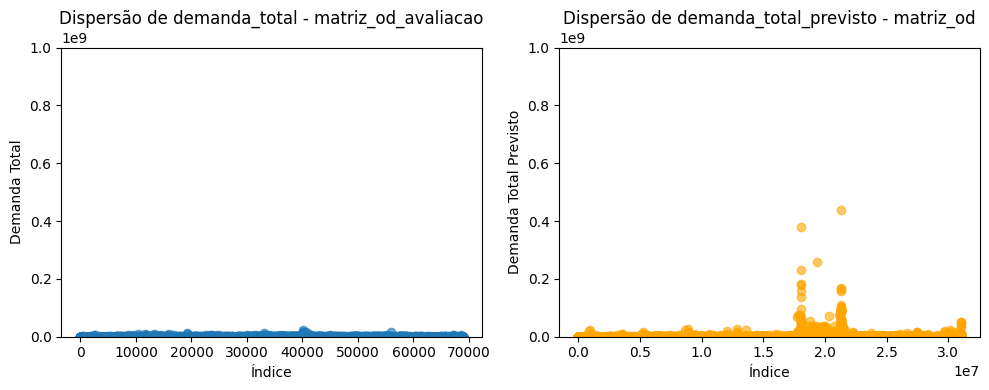

In [88]:
def plotar_graficos_dispersao(matriz_od_avaliacao, matriz_od):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Gráfico de dispersão para demanda_total no DataFrame matriz_od_avaliacao
    axs[0].scatter(matriz_od_avaliacao.index, matriz_od_avaliacao['demanda_total'], alpha=0.6)
    axs[0].set_title('Dispersão de demanda_total - matriz_od_avaliacao')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Demanda Total')

    # Gráfico de dispersão para demanda_total_previsto no DataFrame matriz_od
    axs[1].scatter(matriz_od.index, matriz_od['demanda_total_previsto'], alpha=0.6, color='orange')
    axs[1].set_title('Dispersão de demanda_total_previsto - matriz_od')
    axs[1].set_xlabel('Índice')
    axs[1].set_ylabel('Demanda Total Previsto')

    # Definir o mesmo limite de y para ambos os gráficos com base na matriz_od_avaliacao
    y_min = 0
    y_max = 1000000000
    
    axs[0].set_ylim(y_min, y_max)
    axs[1].set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

# Chame a função com os DataFrames apropriados
plotar_graficos_dispersao(matriz_od_avaliacao, matriz_od)

In [ ]:
def calcular_regressao_share_aero(matriz_od_avaliacao):
    # Remover quaisquer linhas com NaN ou inf
    matriz_od_avaliacao = matriz_od_avaliacao.replace([np.inf, -np.inf], np.nan).dropna(subset=[
        'pib_origem', 'pib_destino', 'pib_per_capita_origem', 'pib_per_capita_destino', 'share_aero'
    ])
    
    # Incluir as dummies de classe_distancia
    dummies_classe_distancia = pd.get_dummies(matriz_od_avaliacao['classe_distancia'], prefix='classe_distancia', drop_first=True)
    dummies_classe_distancia = dummies_classe_distancia.astype(float)
    
    # Variáveis independentes para share_aero
    X_share_aero = matriz_od_avaliacao[['pib_origem', 'pib_destino']]
    X_share_aero = pd.concat([X_share_aero, dummies_classe_distancia], axis=1)
    
    # Variável dependente
    y_share_aero = matriz_od_avaliacao['share_aero']
    
    # Ajustar o modelo de regressão linear para share_aero
    print("Ajustando o modelo linear para share_aero...")
    modelo_share_aero = sm.OLS(y_share_aero, X_share_aero).fit()
    print("\nResumo do modelo linear para share_aero:")
    print(modelo_share_aero.summary())
    
    return modelo_share_aero

modelo_share_aero = calcular_regressao_share_aero(matriz_od_avaliacao)

In [ ]:
def prever_share_aero(matriz_od, modelo_share_aero):
    # Selecionar as variáveis explicativas para previsão
    X_share_aero = matriz_od[['pib_per_capita_origem', 'pib_per_capita_destino', 
                              'turistas_origem', 'turistas_destino']]

    # Adicionar as variáveis dummy de classe_distancia
    dummies_classe_distancia = [col for col in matriz_od.columns if col.startswith('classe_distancia_')]
    X_share_aero = pd.concat([X_share_aero, matriz_od[dummies_classe_distancia]], axis=1)

    # Adicionar constante para o termo de intercepto
    X_share_aero = sm.add_constant(X_share_aero)
    
    # Prever share_aero usando o modelo treinado
    matriz_od['share_aero_previsto'] = modelo_share_aero.predict(X_share_aero)

    # Limitar os valores de share_aero_previsto entre 0 e 1 (0% a 100%)
    matriz_od['share_aero_previsto'] = matriz_od['share_aero_previsto'].clip(lower=0, upper=1)

    return matriz_od

# Executar a função para prever share_aero
matriz_od = prever_share_aero(matriz_od, modelo_share_aero)

In [ ]:
def calcular_demanda_aerea(matriz_od):
    # Calcular demanda_aerea_previsto
    matriz_od['demanda_aerea_previsto'] = matriz_od['demanda_total_previsto'] * matriz_od['share_aero_previsto']
    
    return matriz_od

# Executar a função para calcular demanda_aerea
matriz_od_completa = calcular_demanda_aerea(matriz_od)

In [ ]:
# Ordenar matriz_od_completa em ordem decrescente com base em share_aero_previsto
matriz_od_completa_sorted = matriz_od_completa.sort_values(by='share_aero_previsto', ascending=False)
# Exibir as primeiras linhas do DataFrame ordenado
matriz_od_completa_sorted.head()

,mun_origem,mun_destino,distancia,pib_origem,pib_destino,pop_origem,pop_destino,turistas_origem,turistas_destino,pib_per_capita_origem,pib_per_capita_destino,classe_distancia,classe_distancia_entre 60.0 e 100.0,classe_distancia_entre 100.0 e 250.0,classe_distancia_entre 250.0 e 500.0,classe_distancia_entre 500.0 e 750.0,classe_distancia_entre 750.0 e 1000.0,classe_distancia_entre 1000.0 e 5000.0,classe_distancia_acima de 5000.0,share_aero_previsto
18050078,2304400,3304557,2182.842348,73436128.0,359634753.0,2703391.0,6775561.0,4321169.0,8771112.0,27.164449,53.078225,entre 1000.0 e 5000.0,False,False,False,False,False,True,False,1
18051291,2927408,3304557,1228.792143,62954487.0,359634753.0,2900319.0,6775561.0,4588210.0,8771112.0,21.706056,53.078225,entre 1000.0 e 5000.0,False,False,False,False,False,True,False,1
18050725,2611606,3304557,1882.109140,54970305.0,359634753.0,1661017.0,6775561.0,3840501.0,8771112.0,33.094366,53.078225,entre 1000.0 e 5000.0,False,False,False,False,False,True,False,0.996508
18050292,2408102,3304557,2089.964999,24186262.0,359634753.0,896708.0,6775561.0,3301439.0,8771112.0,26.972283,53.078225,entre 1000.0 e 5000.0,False,False,False,False,False,True,False,0.986406
18054059,4314902,3304557,1105.062545,81562848.0,359634753.0,1492530.0,6775561.0,3197349.0,8771112.0,54.647376,53.078225,entre 1000.0 e 5000.0,False,False,False,False,False,True,False,0.984659


# Comparação de distância e tarifas

In [11]:
def criar_apoio_distancia(rotas_potenciais_filtrado, matriz_od, base_municipios):
    # Adicionando 'nome_origem' e 'nome_destino' com base na correspondência de 'origem' e 'destino' em 'base_municipios'
    rotas_potenciais_filtrado = rotas_potenciais_filtrado.merge(
        base_municipios[['codigo', 'utp']], left_on='cod_mun_origem', right_on='codigo', how='left'
    ).rename(columns={'utp': 'nome_origem'}).drop(columns=['codigo'])
    
    rotas_potenciais_filtrado = rotas_potenciais_filtrado.merge(
        base_municipios[['codigo', 'utp']], left_on='cod_mun_destino', right_on='codigo', how='left'
    ).rename(columns={'utp': 'nome_destino'}).drop(columns=['codigo'])

    # Extraindo e renomeando as colunas necessárias de ambos os DataFrames
    rotas_potenciais = rotas_potenciais_filtrado[['cod_mun_origem', 'cod_mun_destino', 'distancia', 'tarifa', 'nome_origem', 'nome_destino']].rename(
        columns={'cod_mun_origem': 'mun_origem', 'cod_mun_destino': 'mun_destino', 'distancia': 'distancia_rotas_potenciais'}
    ).dropna(subset=['mun_origem', 'mun_destino'])

    matriz_od_distancia = matriz_od[['mun_origem', 'mun_destino', 'distancia']].rename(
        columns={'distancia': 'distancia_matriz_od'}
    ).dropna(subset=['mun_origem', 'mun_destino'])

    # Convertendo 'mun_origem' e 'mun_destino' para int, se necessário
    for col in ['mun_origem', 'mun_destino']:
        rotas_potenciais[col] = rotas_potenciais[col].astype(int)
        matriz_od_distancia[col] = matriz_od_distancia[col].astype(int)

    # Fazendo o merge com base nos pares de 'mun_origem' e 'mun_destino' presentes em rotas_potenciais
    apoio_distancia = pd.merge(
        rotas_potenciais, matriz_od_distancia,
        on=['mun_origem', 'mun_destino'],
        how='left'
    )

    # Calculando a diferença absoluta entre as distâncias
    apoio_distancia['dif_distancia'] = abs(
        apoio_distancia['distancia_matriz_od'] - apoio_distancia['distancia_rotas_potenciais']
    )

    return apoio_distancia

In [12]:
apoio_distancia = criar_apoio_distancia(rotas_potenciais_filtrado, matriz_od, base_municipios)

In [13]:
apoio_distancia = apoio_distancia.sort_values(by='dif_distancia', ascending=False).reset_index(drop=True)

In [14]:
# Exibir as primeiras 20 linhas do DataFrame filtrado
apoio_distancia.head(20)

,mun_origem,mun_destino,distancia_rotas_potenciais,tarifa,nome_origem,nome_destino,distancia_matriz_od,dif_distancia
0,3104809,2919801,1230.404063,427.339954,Curvelo - MG,Macaúbas - BA,576.391098,654.012965
1,3524709,2919801,1790.737200,494.034241,São Paulo - SP,Macaúbas - BA,1155.004756,635.732444
2,3512803,2919801,1790.737200,494.034241,São Paulo - SP,Macaúbas - BA,1158.359068,632.378132
3,3107109,2919801,1563.359928,427.339954,Varginha - MG,Macaúbas - BA,932.306565,631.053362
4,3162005,2919801,1651.708451,427.339954,Pouso Alegre - MG,Macaúbas - BA,1021.707928,630.000523
5,4103107,2919801,2110.236151,527.327783,Curitiba - PR,Macaúbas - BA,1482.008936,628.227216
6,3121001,2919801,1230.404063,427.339954,Curvelo - MG,Macaúbas - BA,602.189710,628.214353
7,3151701,2919801,1651.708451,427.339954,Pouso Alegre - MG,Macaúbas - BA,1024.361917,627.346534
8,3162401,2919801,962.739895,427.339954,Brasília de Minas - MG,Macaúbas - BA,335.843588,626.896307
9,2930154,2919801,740.525156,407.177831,Carinhanha - BA,Macaúbas - BA,114.366501,626.158655


In [37]:
def filtrar_apoio_distancia_1_percent(apoio_distancia):
    # Calcular o total de registros
    total_registros = len(apoio_distancia)

    # Calcular a posição correspondente a 1% do total de registros
    posicao_1_percent = int(total_registros * 0.01)

    # Ordenar o DataFrame pela coluna 'dif_distancia' em ordem decrescente
    apoio_distancia_ordenado = apoio_distancia.sort_values(by='dif_distancia', ascending=False).reset_index(drop=True)

    # Obter o valor de 'dif_distancia' na posição correspondente a 1%
    valor_dif_distancia_1_percent = apoio_distancia_ordenado.iloc[posicao_1_percent - 1]['dif_distancia']

    # Filtrar o DataFrame para remover registros com 'dif_distancia' maior que o valor de 1%
    apoio_distancia_filtrado = apoio_distancia[apoio_distancia['dif_distancia'] <= valor_dif_distancia_1_percent]

    return apoio_distancia_filtrado

In [39]:
apoio_distancia_filtrado = filtrar_apoio_distancia_1_percent(apoio_distancia)

In [45]:
def plot_distancia_tarifa(apoio_distancia_filtrado):
    # Configurar o gráfico de dispersão
    plt.figure(figsize=(16, 6))
    plt.scatter(
        apoio_distancia_filtrado['distancia_rotas_potenciais'], 
        apoio_distancia_filtrado['tarifa'], 
        alpha=0.6, 
        s=1,  # Reduz o tamanho dos pontos
        marker = 'o',
        label = 'Dados'
    )
    
    # Configurações do gráfico
    plt.title("Relação entre Distância e Tarifa")
    plt.xlabel("Distância")
    plt.ylabel("Tarifa")
    plt.grid(True)
    plt.legend()
    plt.show()

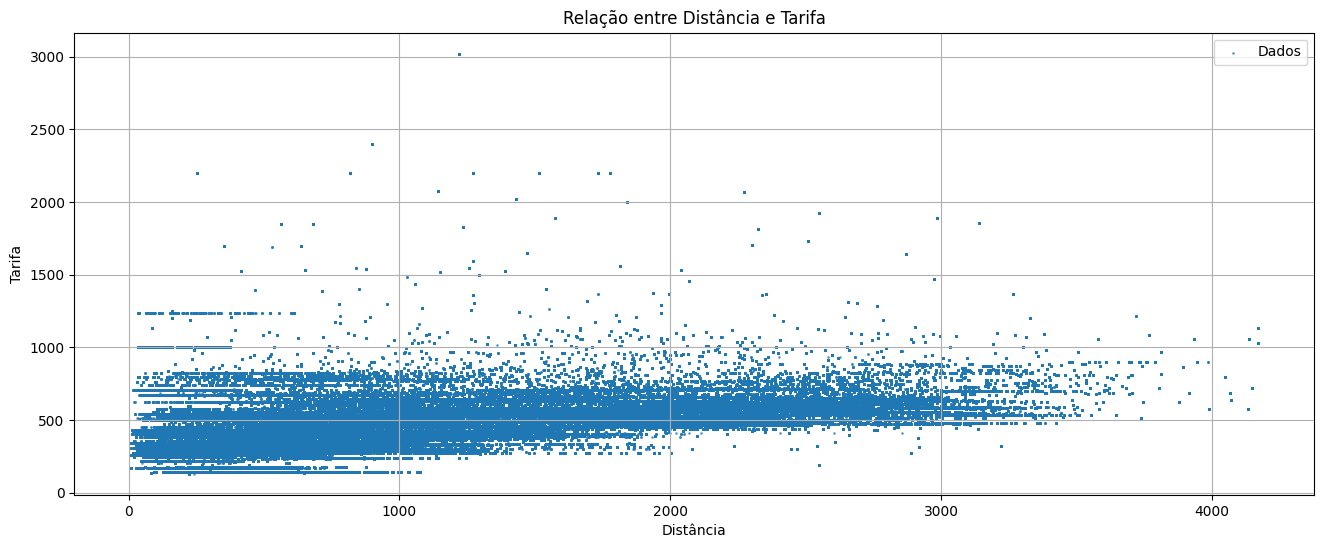

In [46]:
plot_distancia_tarifa(apoio_distancia_filtrado)

In [57]:
def analisar_modelos(apoio_distancia_filtrado):
    # Filtrar dados para evitar log de zero ou negativos e criar uma cópia
    apoio_distancia_filtrado = apoio_distancia_filtrado[apoio_distancia_filtrado['tarifa'] > 0].copy()
    
    # Variáveis independentes e dependente
    x = apoio_distancia_filtrado['distancia_rotas_potenciais']
    y = apoio_distancia_filtrado['tarifa']
    
    # 1. Modelo Linear
    modelo_linear = smf.ols('tarifa ~ distancia_rotas_potenciais', data=apoio_distancia_filtrado).fit()
    print("Modelo Linear:")
    display(modelo_linear.summary())
    
    # 2. Modelo Logarítmico
    apoio_distancia_filtrado['log_distancia'] = np.log(x)
    modelo_logaritmico = smf.ols('tarifa ~ log_distancia', data=apoio_distancia_filtrado).fit()
    print("\nModelo Logarítmico:")
    display(modelo_logaritmico.summary())
    
    # 3. Modelo Exponencial (transformação em ln(y))
    apoio_distancia_filtrado['log_tarifa'] = np.log(y)
    modelo_exponencial = smf.ols('log_tarifa ~ distancia_rotas_potenciais', data=apoio_distancia_filtrado).fit()
    print("\nModelo Exponencial:")
    display(modelo_exponencial.summary())
    
    # 4. Modelo Potencial (transformação em ln(x) e ln(y))
    modelo_potencial = smf.ols('log_tarifa ~ log_distancia', data=apoio_distancia_filtrado).fit()
    print("\nModelo Potencial:")
    display(modelo_potencial.summary())
    
    # 5. Modelo Polinomial (grau 2)
    apoio_distancia_filtrado['distancia_quadrado'] = x ** 2
    modelo_polinomial_grau_2 = smf.ols('tarifa ~ distancia_rotas_potenciais + distancia_quadrado', data=apoio_distancia_filtrado).fit()
    print("\nModelo Polinomial (Grau 2):")
    display(modelo_polinomial_grau_2.summary())
    
    # 6. Modelo Polinomial (grau 3)
    apoio_distancia_filtrado['distancia_cubo'] = x ** 3
    modelo_polinomial_grau_3 = smf.ols('tarifa ~ distancia_rotas_potenciais + distancia_quadrado + distancia_cubo', data=apoio_distancia_filtrado).fit()
    print("\nModelo Polinomial (Grau 3):")
    display(modelo_polinomial_grau_3.summary())

analisar_modelos(apoio_distancia_filtrado)

Modelo Linear:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tarifa   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 1.855e+06
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:27:38   Log-Likelihood:            -3.0204e+07
No. Observations:             4802946   AIC:                         6.041e+07
Df Residuals:                 4802944   BIC:                         6.041e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    339.2148      0.097   3495.964      0.000     339.025     339.405
distancia_rotas_potenciais     0.1047   7.68e-05   1361.876      0.000       0.105       0.105
==============================================================================
Omnibus:                  2407854.468   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28452289.521
Skew:                           2.137   Prob(JB):                         0.00
Kurtosis:                      14.131   Cond. No.                     2.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Modelo Logarítmico:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tarifa   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                 1.257e+06
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:27:39   Log-Likelihood:            -3.0430e+07
No. Observations:             4802946   AIC:                         6.086e+07
Df Residuals:                 4802944   BIC:                         6.086e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -71.9851      0.464   -155.074      0.000     -72.895     -71.075
log_distancia    78.5521      0.070   1120.960      0.000      78.415      78.689
==============================================================================
Omnibus:                  2136703.297   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21307992.246
Skew:                           1.886   Prob(JB):                         0.00
Kurtosis:                      12.604   Cond. No.                         50.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Modelo Exponencial:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_tarifa   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 2.173e+06
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:27:41   Log-Likelihood:            -7.5677e+05
No. Observations:             4802946   AIC:                         1.514e+06
Df Residuals:                 4802944   BIC:                         1.514e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      5.7917      0.000   2.75e+04      0.000       5.791       5.792
distancia_rotas_potenciais     0.0002   1.67e-07   1473.980      0.000       0.000       0.000
==============================================================================
Omnibus:                   370935.629   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           893384.469
Skew:                           0.475   Prob(JB):                         0.00
Kurtosis:                       4.887   Cond. No.                     2.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Modelo Potencial:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_tarifa   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                 1.560e+06
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:27:43   Log-Likelihood:            -9.7756e+05
No. Observations:             4802946   AIC:                         1.955e+06
Df Residuals:                 4802944   BIC:                         1.955e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.7897      0.001   4750.911      0.000       4.788       4.792
log_distancia     0.1901      0.000   1248.956      0.000       0.190       0.190
==============================================================================
Omnibus:                   305319.681   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           836019.454
Skew:                           0.352   Prob(JB):                         0.00
Kurtosis:                       4.919   Cond. No.                         50.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Modelo Polinomial (Grau 2):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tarifa   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 9.277e+05
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:27:45   Log-Likelihood:            -3.0204e+07
No. Observations:             4802946   AIC:                         6.041e+07
Df Residuals:                 4802943   BIC:                         6.041e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    336.5805      0.147   2291.312      0.000     336.293     336.868
distancia_rotas_potenciais     0.1110      0.000    400.197      0.000       0.110       0.112
distancia_quadrado         -2.333e-06   9.77e-08    -23.885      0.000   -2.52e-06   -2.14e-06
==============================================================================
Omnibus:                  2412092.670   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28550929.502
Skew:                           2.142   Prob(JB):                         0.00
Kurtosis:                      14.150   Cond. No.                     6.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Modelo Polinomial (Grau 3):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tarifa   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                 6.367e+05
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:27:47   Log-Likelihood:            -3.0184e+07
No. Observations:             4802946   AIC:                         6.037e+07
Df Residuals:                 4802942   BIC:                         6.037e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    365.6888      0.207   1765.207      0.000     365.283     366.095
distancia_rotas_potenciais    -0.0003      0.001     -0.520      0.603      -0.002       0.001
distancia_quadrado          9.049e-05   4.78e-07    189.409      0.000    8.96e-05    9.14e-05
distancia_cubo             -2.046e-08   1.03e-10   -198.449      0.000   -2.07e-08   -2.03e-08
==============================================================================
Omnibus:                  2432972.863   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28780705.031
Skew:                           2.166   Prob(JB):                         0.00
Kurtosis:                      14.182   Cond. No.                     2.40e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

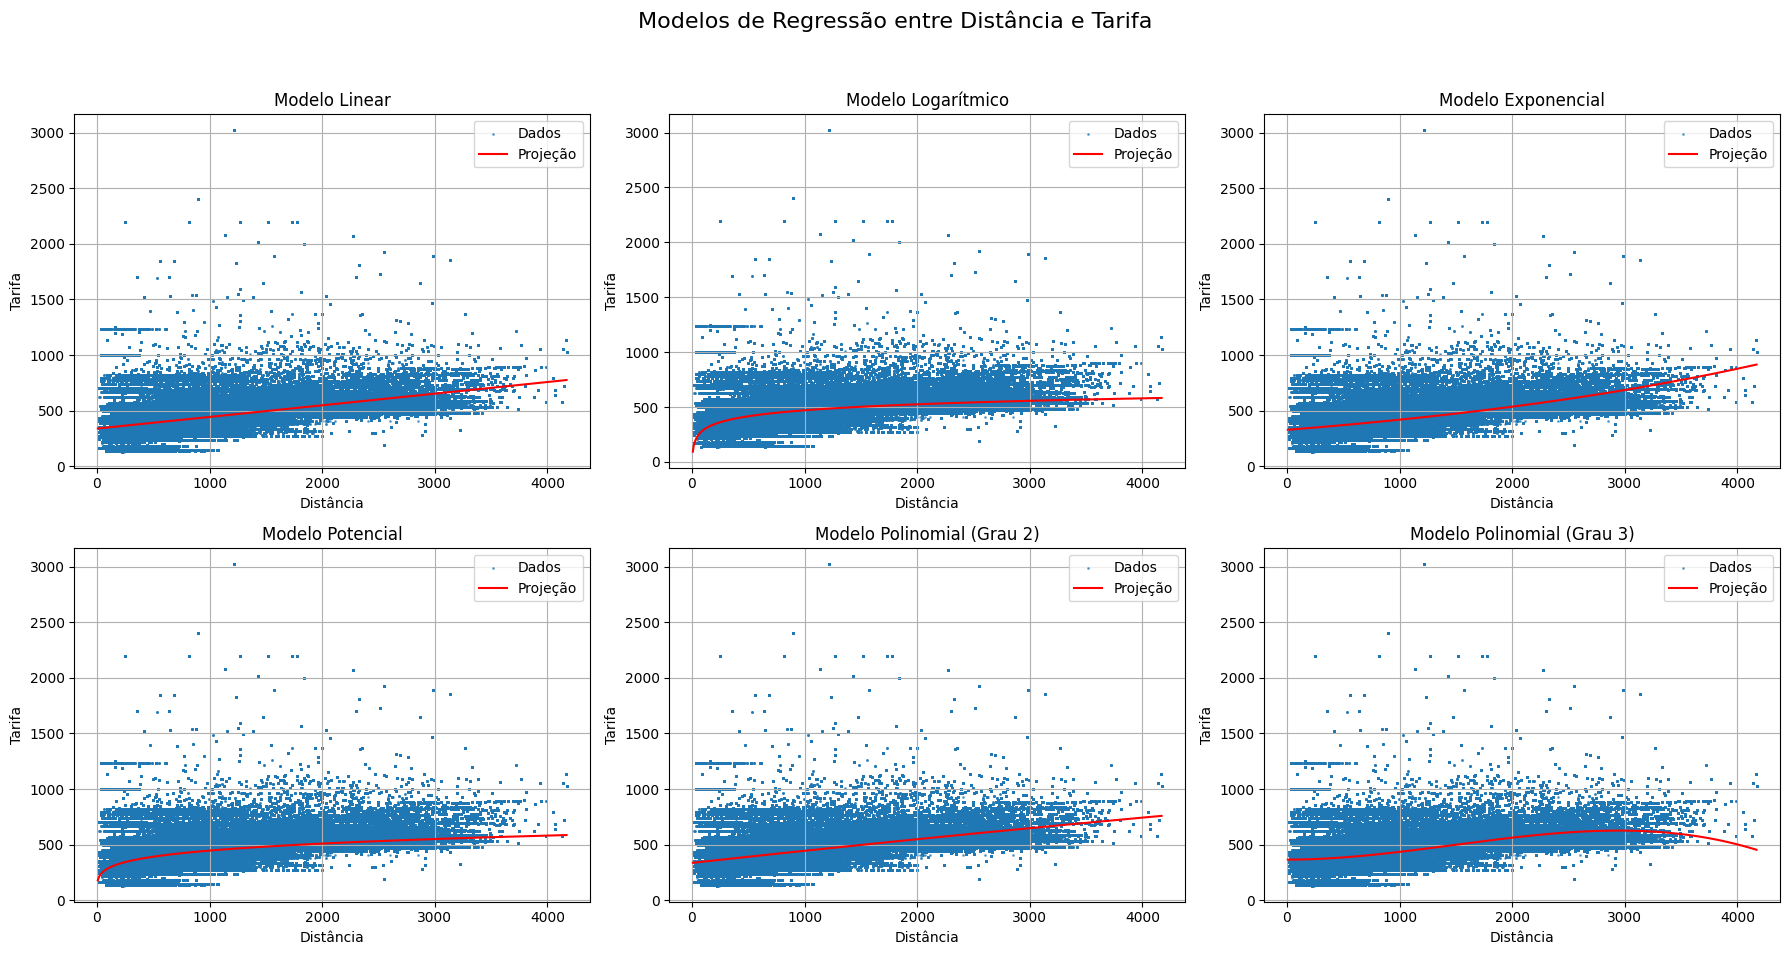

In [58]:
def plot_distancia_tarifa_modelos(apoio_distancia_filtrado):
    # Filtrar dados para evitar log de zero ou negativos e criar uma cópia
    apoio_distancia_filtrado = apoio_distancia_filtrado[apoio_distancia_filtrado['tarifa'] > 0].copy()
    
    # Variáveis independentes e dependente
    x = apoio_distancia_filtrado['distancia_rotas_potenciais']
    y = apoio_distancia_filtrado['tarifa']
    
    # Transformações necessárias
    apoio_distancia_filtrado['log_distancia'] = np.log(x)
    apoio_distancia_filtrado['log_tarifa'] = np.log(y)
    apoio_distancia_filtrado['distancia_quadrado'] = x ** 2
    apoio_distancia_filtrado['distancia_cubo'] = x ** 3
    
    # Ajuste de cada modelo
    modelo_linear = smf.ols('tarifa ~ distancia_rotas_potenciais', data=apoio_distancia_filtrado).fit()
    modelo_logaritmico = smf.ols('tarifa ~ log_distancia', data=apoio_distancia_filtrado).fit()
    modelo_exponencial = smf.ols('log_tarifa ~ distancia_rotas_potenciais', data=apoio_distancia_filtrado).fit()
    modelo_potencial = smf.ols('log_tarifa ~ log_distancia', data=apoio_distancia_filtrado).fit()
    modelo_polinomial_grau_2 = smf.ols('tarifa ~ distancia_rotas_potenciais + distancia_quadrado', data=apoio_distancia_filtrado).fit()
    modelo_polinomial_grau_3 = smf.ols('tarifa ~ distancia_rotas_potenciais + distancia_quadrado + distancia_cubo', data=apoio_distancia_filtrado).fit()
    
    # Configurar a matriz de subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Modelos de Regressão entre Distância e Tarifa", fontsize=16)
    
    # Definir os dados de x para as projeções
    x_vals = np.linspace(min(x), max(x), 500)
    
    # Gráfico 1: Modelo Linear
    axes[0, 0].scatter(x, y, s=1, alpha=0.6, label='Dados')
    axes[0, 0].plot(x_vals, modelo_linear.predict(exog=dict(distancia_rotas_potenciais=x_vals)), color='red', label='Projeção')
    axes[0, 0].set_title("Modelo Linear")
    
    # Gráfico 2: Modelo Logarítmico
    axes[0, 1].scatter(x, y, s=1, alpha=0.6, label='Dados')
    axes[0, 1].plot(x_vals, modelo_logaritmico.predict(exog=dict(log_distancia=np.log(x_vals))), color='red', label='Projeção')
    axes[0, 1].set_title("Modelo Logarítmico")
    
    # Gráfico 3: Modelo Exponencial
    axes[0, 2].scatter(x, y, s=1, alpha=0.6, label='Dados')
    axes[0, 2].plot(x_vals, np.exp(modelo_exponencial.predict(exog=dict(distancia_rotas_potenciais=x_vals))), color='red', label='Projeção')
    axes[0, 2].set_title("Modelo Exponencial")
    
    # Gráfico 4: Modelo Potencial
    axes[1, 0].scatter(x, y, s=1, alpha=0.6, label='Dados')
    axes[1, 0].plot(x_vals, np.exp(modelo_potencial.predict(exog=dict(log_distancia=np.log(x_vals)))), color='red', label='Projeção')
    axes[1, 0].set_title("Modelo Potencial")
    
    # Gráfico 5: Modelo Polinomial (Grau 2)
    axes[1, 1].scatter(x, y, s=1, alpha=0.6, label='Dados')
    axes[1, 1].plot(x_vals, modelo_polinomial_grau_2.predict(exog=dict(distancia_rotas_potenciais=x_vals, distancia_quadrado=x_vals**2)), color='red', label='Projeção')
    axes[1, 1].set_title("Modelo Polinomial (Grau 2)")
    
    # Gráfico 6: Modelo Polinomial (Grau 3)
    axes[1, 2].scatter(x, y, s=1, alpha=0.6, label='Dados')
    axes[1, 2].plot(x_vals, modelo_polinomial_grau_3.predict(exog=dict(distancia_rotas_potenciais=x_vals, distancia_quadrado=x_vals**2, distancia_cubo=x_vals**3)), color='red', label='Projeção')
    axes[1, 2].set_title("Modelo Polinomial (Grau 3)")
    
    # Configurações adicionais
    for ax in axes.flat:
        ax.set_xlabel("Distância")
        ax.set_ylabel("Tarifa")
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste para o título principal
    plt.show()

plot_distancia_tarifa_modelos(apoio_distancia_filtrado)

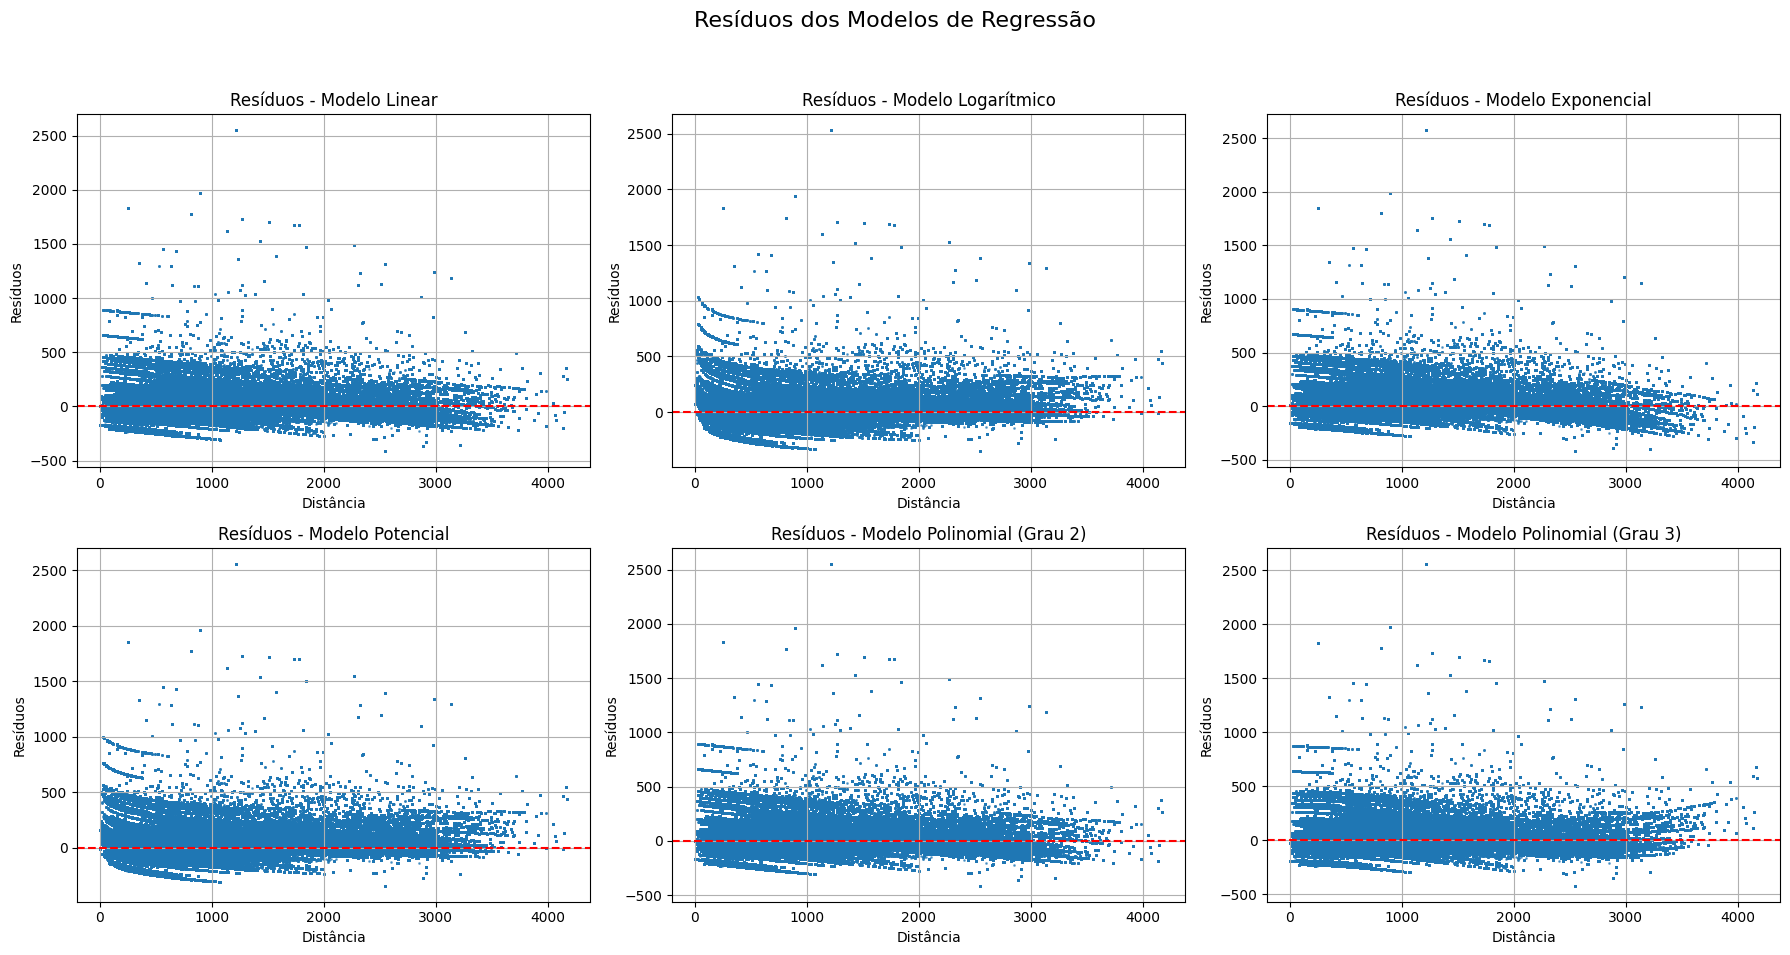

In [59]:
def plot_residuos_modelos(apoio_distancia_filtrado):
    # Filtrar dados para evitar log de zero ou negativos e criar uma cópia
    apoio_distancia_filtrado = apoio_distancia_filtrado[apoio_distancia_filtrado['tarifa'] > 0].copy()
    
    # Variáveis independentes e dependente
    x = apoio_distancia_filtrado['distancia_rotas_potenciais']
    y = apoio_distancia_filtrado['tarifa']
    
    # Transformações necessárias
    apoio_distancia_filtrado['log_distancia'] = np.log(x)
    apoio_distancia_filtrado['log_tarifa'] = np.log(y)
    apoio_distancia_filtrado['distancia_quadrado'] = x ** 2
    apoio_distancia_filtrado['distancia_cubo'] = x ** 3
    
    # Ajuste de cada modelo e cálculo dos resíduos
    modelo_linear = smf.ols('tarifa ~ distancia_rotas_potenciais', data=apoio_distancia_filtrado).fit()
    residuos_linear = y - modelo_linear.predict(apoio_distancia_filtrado)

    modelo_logaritmico = smf.ols('tarifa ~ log_distancia', data=apoio_distancia_filtrado).fit()
    residuos_logaritmico = y - modelo_logaritmico.predict(apoio_distancia_filtrado)

    modelo_exponencial = smf.ols('log_tarifa ~ distancia_rotas_potenciais', data=apoio_distancia_filtrado).fit()
    residuos_exponencial = y - np.exp(modelo_exponencial.predict(apoio_distancia_filtrado))

    modelo_potencial = smf.ols('log_tarifa ~ log_distancia', data=apoio_distancia_filtrado).fit()
    residuos_potencial = y - np.exp(modelo_potencial.predict(apoio_distancia_filtrado))

    modelo_polinomial_grau_2 = smf.ols('tarifa ~ distancia_rotas_potenciais + distancia_quadrado', data=apoio_distancia_filtrado).fit()
    residuos_polinomial_grau_2 = y - modelo_polinomial_grau_2.predict(apoio_distancia_filtrado)

    modelo_polinomial_grau_3 = smf.ols('tarifa ~ distancia_rotas_potenciais + distancia_quadrado + distancia_cubo', data=apoio_distancia_filtrado).fit()
    residuos_polinomial_grau_3 = y - modelo_polinomial_grau_3.predict(apoio_distancia_filtrado)
    
    # Configurar a matriz de subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Resíduos dos Modelos de Regressão", fontsize=16)
    
    # Gráfico 1: Modelo Linear
    axes[0, 0].scatter(x, residuos_linear, s=1, alpha=0.6)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_title("Resíduos - Modelo Linear")
    
    # Gráfico 2: Modelo Logarítmico
    axes[0, 1].scatter(x, residuos_logaritmico, s=1, alpha=0.6)
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_title("Resíduos - Modelo Logarítmico")
    
    # Gráfico 3: Modelo Exponencial
    axes[0, 2].scatter(x, residuos_exponencial, s=1, alpha=0.6)
    axes[0, 2].axhline(y=0, color='red', linestyle='--')
    axes[0, 2].set_title("Resíduos - Modelo Exponencial")
    
    # Gráfico 4: Modelo Potencial
    axes[1, 0].scatter(x, residuos_potencial, s=1, alpha=0.6)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_title("Resíduos - Modelo Potencial")
    
    # Gráfico 5: Modelo Polinomial (Grau 2)
    axes[1, 1].scatter(x, residuos_polinomial_grau_2, s=1, alpha=0.6)
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_title("Resíduos - Modelo Polinomial (Grau 2)")
    
    # Gráfico 6: Modelo Polinomial (Grau 3)
    axes[1, 2].scatter(x, residuos_polinomial_grau_3, s=1, alpha=0.6)
    axes[1, 2].axhline(y=0, color='red', linestyle='--')
    axes[1, 2].set_title("Resíduos - Modelo Polinomial (Grau 3)")
    
    # Configurações adicionais
    for ax in axes.flat:
        ax.set_xlabel("Distância")
        ax.set_ylabel("Resíduos")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste para o título principal
    plt.show()

plot_residuos_modelos(apoio_distancia_filtrado)